![image](../../images/618_tutorials_banner_logos.png)

# SHIFT Data Access
---
**Summary**

Welcome to the 618 Biospheric Lab Earth Observation tutorial GitHub! A repository that is in development to showcase useful remote sensing datasets, data processing skills, and analyses using datasets produced in-house (e.g., [GLiHT](https://gliht.gsfc.nasa.gov/)) and across NASA and other open source projects (e.g., Landsat and Sentinel-2).

This notebook demonstrates how to access [SHIFT Orthorectified Surface Reflectance, V2](https://www.earthdata.nasa.gov/data/catalog/ornl-cloud-shift-avng-l2a-rfl-v2-2431-2) data from NASA Earthdata using the earthaccess API.
With earthaccess, you can query any dataset available on Earthdata Search using spatial, temporal, or other supported parameters. After identifying your area of interest (AOI), the API can directly access the data in S3, no local downloads required.

In this notebook, we’ll walk through configuring access, selecting and cropping data for your AOI, and visualizing the results using Python libraries such as Xarray, Rioxarray, and Dask.

**Learning Objectives**
- Access Earthdata Search datasets programatically
- Interact with data without downloading it locally
- Use Dask’s lazy execution for efficient processing
- Generate and display an RGB composite
  
#### Contact Info**

**Author:** Evan Lang (Github: [EvanDLang](https://github.com/evandlang)), Yoseline Angel (Github: [Yoselineangel]( https://github.com/yoselineangel))  
**Last Update:** 2025-11-20 (Created: 2025-11-20)  
**Website:** <https://github.com/GSFC-618/618-tutorials>


## Environment Setup 
**Environment:** conda env create -f [shift-data-access-tutorial-20251120.yaml](https://github.com/GSFC-618/618-tutorials/tree/main/envs)

In [1]:
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthaccess
from rioxarray.merge import merge_arrays
import numpy as np
import re
import earthaccess
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import tqdm

In [2]:
output_name = "SHIFT_Merged_Scene.tif"

## Authentication 
To follow this tutorial, you will need an [Earthdata Login account](https://urs.earthdata.nasa.gov/users/new). Once you have an account, you can use your credentials to access the earthaccess API.

The cell below will prompt you for your username and password. By using the `persist=True` argument, your credentials will be saved locally, so you won’t need to re-enter them each time.

In [3]:
auth = earthaccess.login(persist=True)

## SHIFT V2 Reflectance Data
The SHIFT V2 data is Level 2A orthorectified hyperspectral surface reflectance imagery collected by NASA's AVIRIS-NG instrument during the 2022 SHIFT campaign over Santa Barbara County, California. AVIRIS-NG measures reflected radiance at 5 nm intervals in the Visible to Shortwave Infrared (VSWIR) spectral range from ~380–2500 nm. Each flight line includes orthorectified surface reflectance and uncertainty in netCDF format, along with ancillary files documenting processing parameters.

### Data file structure
The SHIFT data are organized by flightlines. Due to the large size of each orthorectified flightline, the data have been split into smaller units (i.e., tiles) to make the data easier to work with.
Each file has a name similar to:
```
AVIRIS-NG_SHIFT_V2_L2A_ang20220915t213504_002_RFL
```
Where: 

- `ang20220915t213504` is the flightline
- `0220915` is the date the data were recorded
- `002` indicates what subsection of the flightline we are working with


### What is lazy execution
The Dask library enables lazy execution, meaning you can queue a series of operations on a dataset and execute them later at a time of your choosing. Dask reads data in chunks, using the native NetCDF structure, which allows it to pull only portions of the data into memory at a time. This approach makes memory usage more efficient and enables analysis of large datasets even in memory-constrained environments.

### Working with SHIFT Data
In this notebook we will use a shapefile to query multiple days worth of SHIFT data. We will then organize and merge together the data for a given day and then plot an RGB image.

The following code demonstrates how to access SHIFT data via the earthaccess API. The steps include:
- Find the dataset’s short_name via Earthdata Search
- Open a shapefile and extract coordinates using GeoPandas
- Use earthaccess to retrieve the data for a given area of interest
- Use Dask arrays to allow for lazy execution
- Crop the data lazily using Rioxarray
- Merge cropped data for a given day
- Plot an RGB composite of the merged data
  
### Getting started
The first thing we are going to do is retrieve the name of the dataset for use with the API. The easiest way to find the dataset’s name is to locate the collection first on Earthdata Search. Once you open the collection, the short_name can be found in the collection information, as highlighted in the image below.


This method of finding data on earth access can be used to access any dataset on Earthdata Search by specifying the dataset’s `short_name`.


![image](../../images/earthdatasearch_metadata.jpg)

### Area of interest

For the tutorial we have a provided shapefile that can be found here: [shift_tutorial.shp](https://github.com/GSFC-618/618-tutorials/tree/main/shapefiles). The shapefile is located in the Jack and Laura Dangermond Preserve near Santa Barbra California, The site of the SHIFT Airborne Campaign. The shapefile CRS is EPSG:32610, but we are going to be converting it the EPSG:4326 so the CRS matches Earthdata search

Read the shapefile using GeoPandas and convert the CRS to EPSG:4326

In [4]:
gdf = gpd.read_file('../../shapefiles/shift_tutorial.shp').to_crs("EPSG:4326")
print(gdf.crs)

# Retrive the coordinates and reverse them so they are oriented counter clockwise (This is a requirement for the API)
coords = list(gdf.iloc[0].geometry.exterior.coords)[::-1] 
coords

EPSG:4326


[(-120.42401838523695, 34.50982500275268),
 (-120.39598114109539, 34.509230202263275),
 (-120.39532549028584, 34.530283578542075),
 (-120.42336977461555, 34.530878844573195),
 (-120.42401838523695, 34.50982500275268)]

Now That we have our polygon, we can visualize it to understand the extent of the area of interest.

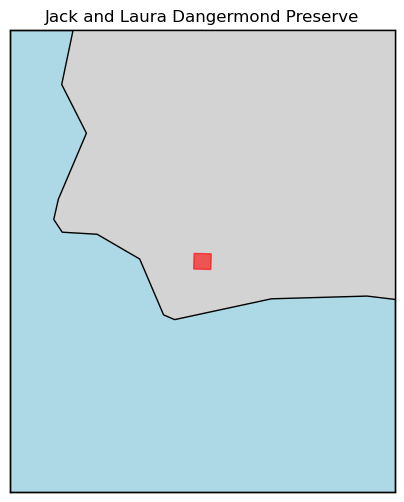

In [5]:
# Split into lon/lat arrays
lon_array, lat_array = zip(*coords)

# Use margin to adjust zoom
margin = 0.3
minx, maxx = min(lon_array) - margin, max(lon_array) + margin
miny, maxy = min(lat_array) - margin, max(lat_array) + margin

# Create Figure
fig, ax = plt.subplots(figsize=(6, 6))

# Create Basemap
m = Basemap(
    projection='merc',
    llcrnrlon=minx, llcrnrlat=miny,
    urcrnrlon=maxx, urcrnrlat=maxy,
    resolution='i',
    ax=ax
)

# Draw map features
m.drawcoastlines()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Convert polygon coords to map projection
x, y = m(lon_array, lat_array)

# Fill the polygon in red
plt.fill(x, y, color='red', alpha=0.6)

plt.title("Jack and Laura Dangermond Preserve")
plt.show()


Query SHIFT reflectance using the coordinates from above and a date range

In [6]:
results = earthaccess.search_data(short_name='SHIFT_AVNG_L2A_RFL_V2_2431', polygon=coords, temporal=("2022-01-01", "2022-03-15"))
len(results)

18

Each result will have the following files available for use

In [7]:
results[0].data_links()

['https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t204803_002_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t204803_002_L2A_OE_f6d5005c.yaml',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t204803_002_L2A_OE_f6d5005c_RFL_ORT.tif',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t204803_002_L2A_OE_f6d5005c_UNC_ORT.nc']

Gather all the reflectance data.

In [8]:
rfl = [r.data_links()[0] for r in results]
rfl

['https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t204803_002_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t210144_007_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t210144_008_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t211618_001_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t211618_002_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220224t213004_007_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.nasa.gov/protected/shift/SHIFT_AVNG_L2A_RFL_V2/data/ang20220228t194708_006_L2A_OE_f6d5005c_RFL_ORT.nc',
 'https://data.ornldaac.earthdata.

Extract dates from file names.

In [9]:
dates = []
for url in rfl:
    match = re.search(r'ang(\d{8})t', url)
    if match:
        date = datetime.strptime(match.group(1), "%Y%m%d")
        dates.append(date)

len(dates)

18

Use earth access to open all the files directly from S3 or https depending on region.

In [10]:
opened_rfl = earthaccess.open(rfl)

QUEUEING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/18 [00:00<?, ?it/s]

Loop through the datasets and format them. The netCDFs have multiple groups that need to be opened and merged together.

For the reflectance group, provide the chunks argument to open_dataset to open the data as a Dask array. Using an empty dictionary preserves the native chunking pattern. Avoid resizing chunks to prevent unnecessary loading and rechunking before other operations.

For the root group, which contains location information (coordinates and CRS), do not provide the chunks argument and load it fully into memory. This dataset is small, so loading it does not impact performance. Opening multiple groups from the same NetCDF file can sometimes cause the backend libraries to stall due to simultaneous file access issues. If this occurs, stopping and restarting the Jupyter cell can allow the operation to continue successfully.

The mask_and_scale argument controls the nodata value. If set to True, Xarray will read in the nodata values as NaNs. If it is set to False, it will use the encoded nodata value. In this case that is -9999.0. When working in Python I perfer to use the NaNs.

Additionaly, we are going to rename the dimensions renaming the northing and easting to y and x. This will come into play when we are trying to write the results.

In [12]:
datasets = []
for f in tqdm.tqdm(opened_rfl):
    rfl = xr.open_dataset(f, group='reflectance', chunks={}, mask_and_scale=True)
    loc = xr.open_dataset(f, mask_and_scale=True).load()
    datasets += [xr.merge([rfl, loc]).rio.write_crs(loc.transverse_mercator.attrs['spatial_ref']).rename({'northing': 'y', 'easting': 'x'})]

100%|██████████| 18/18 [00:00<00:00, 24.94it/s]


Use Rioxarray and the polygon to crop the datasets. Make sure to convert the geodataframe to the CRS of the reflectance file. Because we are using Dask arrays this opertion is executed lazily!

In [13]:
cropped_datasets = [ds.reflectance.rio.clip([gdf.to_crs(ds.rio.crs).iloc[0].geometry]) for ds in datasets] 
len(cropped_datasets)

18

In [14]:
cropped_datasets[0]

<xarray.DataArray 'reflectance' (wavelength: 425, y: 63, x: 560)> Size: 60MB
dask.array<getitem, shape=(425, 63, 560), dtype=float32, chunksize=(10, 63, 256), chunktype=numpy.ndarray>
Coordinates:
  * wavelength           (wavelength) float32 2kB 377.2 382.2 ... 2.501e+03
  * y                    (y) float64 504B 3.824e+06 3.824e+06 ... 3.824e+06
  * x                    (x) float64 4kB 7.365e+05 7.365e+05 ... 7.391e+05
    spatial_ref          int64 8B 0
    transverse_mercator  int64 8B 0
Attributes:
    _QuantizeBitGroomNumberOfSignificantDigits:  5
    long_name:                                   Surface hemispherical direct...
    orthorectified:                              True

Using Numpy where we can organize the data by date. We can the indicies to slice our cropped data list and retrieve all the data for a given day

In [15]:
rfl_by_date  = {}
for date in np.unique(np.array(dates)):
    indices = np.where(np.array(dates) == date)[0]
    rfl_by_date[date.strftime("%Y-%m-%d")] = [cropped_datasets[i] for i in indices]

list(rfl_by_date.keys())    

['2022-02-24', '2022-02-28', '2022-03-08']

Next, we will merge all of the reflectance files for a given day using Rioxarray’s `merge_arrays` function. **Note**: depending on your area of interest, there may be images containing pixels that overlap with other image pixels. The `method` argument in `merge_arrays` defaults to using the first pixel if there are overlapping pixels. This can be changed to one of `first`, `last`, `min`, `max`, `sum`, or a custom method for median or mean, for example.

Up until now, all operations have been performed lazily, meaning the data has not yet been loaded into memory. Running merge_arrays will pull all the data from S3 into memory, which can be very memory-intensive. If your area of interest is large, your kernel may crash.

Depending on your computing resources, you may need to further segment your AOI to avoid memory issues. This operation may take some time to complete.

In [16]:
%%time
merged = merge_arrays(rfl_by_date['2022-02-28'], method = "first")
merged

CPU times: user 32.6 s, sys: 4.65 s, total: 37.2 s
Wall time: 1min 19s


<xarray.DataArray 'reflectance' (wavelength: 425, y: 509, x: 561)> Size: 485MB
array([[[ 4.03262377e-02,  5.43088876e-02,  5.13185263e-02, ...,
          3.55235338e-02,  2.42377501e-02,             nan],
        [ 5.33097982e-02,  4.86586057e-02,  5.18440008e-02, ...,
          2.01460719e-02,  2.99469810e-02,             nan],
        [ 5.38628101e-02,  5.25121652e-02,  4.05530930e-02, ...,
          2.46832967e-02,  2.97997575e-02,             nan],
        ...,
        [ 3.29213142e-02,  3.06207519e-02,  2.14934945e-02, ...,
          3.96777354e-02,  3.66780758e-02,             nan],
        [ 2.76181698e-02,  2.44563203e-02,  3.13298702e-02, ...,
          4.74380217e-02,  3.87433767e-02,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 9.16576385e-03,  7.49863638e-03,  1.70172453e-02, ...,
          1.92443281e-03, -1.42692390e-03,             nan],
        [ 1.69544220e-02,  9.14299395e-03,  1.00239217e-02, ...,
         -2.95884162e-03, -8.66756236e-05,             nan],
        [ 1.82889104e-02,  1.72266942e-02,  1.71441436e-02, ...,
          2.18349695e-03,  1.27857539e-03,             nan],
...
          5.89585267e-02,  6.73172474e-02,             nan],
        [ 3.75735760e-02,  4.38626967e-02,  4.14311886e-02, ...,
          6.59038946e-02,  6.47633076e-02,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 8.19599628e-02,  7.28294775e-02,  7.24358559e-02, ...,
          3.14251184e-02,  2.87564378e-02,             nan],
        [ 8.49680901e-02,  7.06188604e-02,  7.73823261e-02, ...,
          2.60330439e-02,  2.56364923e-02,             nan],
        [ 9.49263573e-02,  8.55512545e-02,  7.07013607e-02, ...,
          2.90323496e-02,  2.61103492e-02,             nan],
        ...,
        [ 2.41321325e-02,  3.23587619e-02,  2.02121735e-02, ...,
          4.43438254e-02,  4.55144644e-02,             nan],
        [ 2.72265077e-02,  3.08460575e-02,  2.61390805e-02, ...,
          5.06346188e-02,  4.91135120e-02,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]],
      shape=(425, 509, 561), dtype=float32)
Coordinates:
  * wavelength           (wavelength) float32 2kB 377.2 382.2 ... 2.501e+03
  * y                    (y) float64 4kB 3.824e+06 3.824e+06 ... 3.822e+06
  * x                    (x) float64 4kB 7.365e+05 7.365e+05 ... 7.391e+05
    transverse_mercator  int64 8B 0
Attributes:
    _QuantizeBitGroomNumberOfSignificantDigits:  5
    long_name:                                   Surface hemispherical direct...
    orthorectified:                              True
    _FillValue:                                  nan

## Vizualize


To visualize the data, we will plot an RGB image of the AOI. We select bands within the red, green, and blue portions of the visible light spectrum (640 nm, 550 nm, and 480 nm), and transpose the data to a format compatible with Matplotlib.

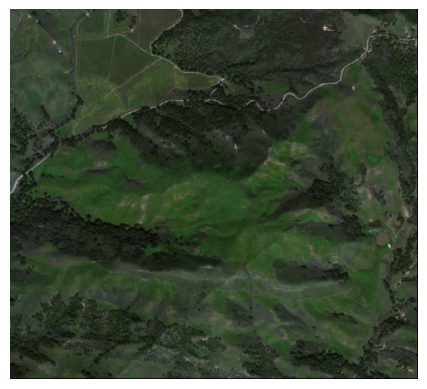

In [17]:
rgb = merged.sel(wavelength=[640, 550, 480], method="nearest").transpose('y','x','wavelength').values

# replace all the NaNs with 0
rgb = np.nan_to_num(np.clip(rgb, 0, None))
# Find the mins and maxs of each band
band_min = rgb.min(axis=(0,1), keepdims=True)
band_max = rgb.max(axis=(0,1), keepdims=True)
# normalize the bands using the mins and maxs
rgb_normalized = (rgb - band_min) / (band_max - band_min)

# Brighten the image using gamma correction
gamma = 1.2
rgb_corrected = rgb_normalized ** (1 / gamma)

plt.imshow(rgb_corrected)
plt.axis("off")
plt.show()


## Write our merged raster as a Tif

We can use rioxarray to write our original merged raster as a Tif. Rioxarray's to_raster function requires that the dimensions are (band, y, x) and you need to remove the _FillValue from the DataArray attributes. Rioxarray is just a wrapper around rasterio, which supports any file type supported by GDAL.

In [17]:
merged.attrs.pop("_FillValue")
merged.rio.to_raster(output_name, dtype="float32")